In [1]:
"""
Purpose: 
To look how the number of shared inputs changes with the RF center difference

Should see it go up as RF center distance goes down

"""

'\nPurpose: \nTo look how the number of shared inputs changes with the RF center difference\n\nShould see it go up as RF center distance goes down\n\n'

# Where to find the RF centers: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting celiib@10.28.0.34:3306


In [3]:
#setting the address and the username
dj.config['database.host'] = '10.28.0.34'
dj.config['database.user'] = 'celiib'
dj.config['database.password'] = 'newceliipass'
dj.config['safemode']=True
dj.config["display.limit"] = 20


pinky = dj.create_virtual_module('pinky', 'microns_pinky')
pinky_nda = dj.create_virtual_module('pinky_nda', 'microns_pinky_nda')
radtune = dj.create_virtual_module('pinky_radtune', 'microns_pinky_radtune')
spattune = dj.create_virtual_module('pinky_spattune', 'microns_pinky_spattune')
fc = dj.create_virtual_module('pinky_fc', 'microns_pinky_fc')


In [4]:
"""
WHERE THE RF CORRELATION BINS ARE EXPLICITELY SET
"""

attrs = ['segment_a', 'segment_b', 'connection', 'n_seg_shared']
good_rf = 'mscore > 1.50'

rf_bin_edges = np.linspace(-.7, .7, 6) #setting the bin boundaries


"""
Calculate the bins and centers for the orientational preference
"""
#defines how to find the "tuned" segments of the orientation
dori_resolution = np.pi / 2 / 4 #setting the width size of the bins to be 22.5 degrees
rad2deg = 180/np.pi
bin_edges = np.linspace(0, np.pi,9) #creates 8 bins between boundaries between 0 and pi


# doing the synaptic Volume Density Correlation vs. RF Centers

/usr/local/lib/python3.6/dist-packages/datajoint/connection.py:150: UserWarning: Mysql server has gone away. Reconnecting to the server.
  warnings.warn("Mysql server has gone away. Reconnecting to the server.")


Number of significant receptive field neurons = 199
Length of rf correlation = 17770
Number of significanlty orientationally tuned neurons = 926
Length of pairwise orientation difference table = 428275
sign_contact_correlations_only_shared_threshold = 304812
sign_contact_correlations with both shared number threshold and shared number converted threshold = 297726
len(shi) = 314028
len(shi restricted by the contact correlations with n_seg_shared threshold) = 151919
len(shi restricted by the contact correlations with n_seg_shared threshold AND converted threshold) = 146876
(13700, 7259)


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


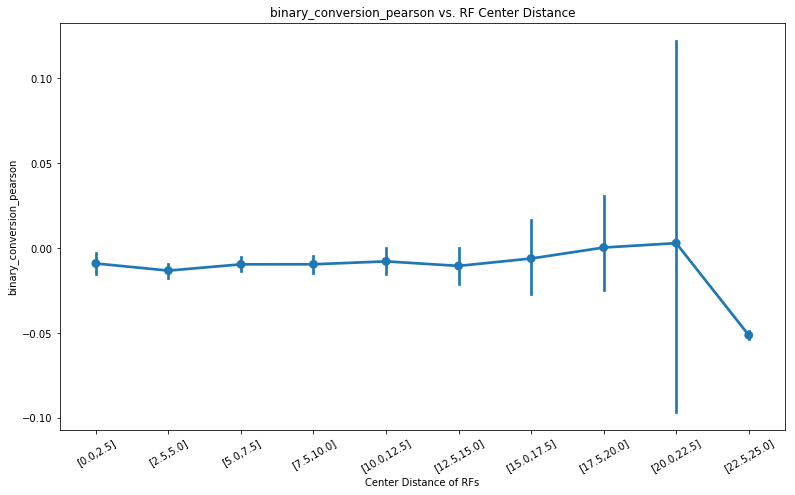

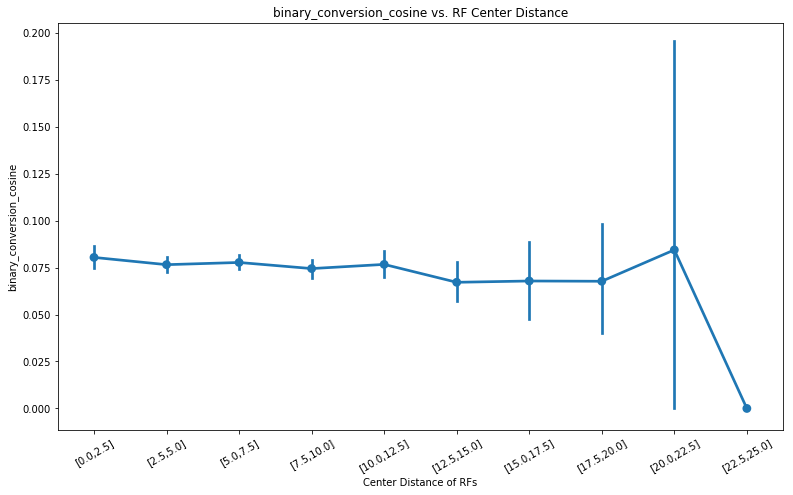

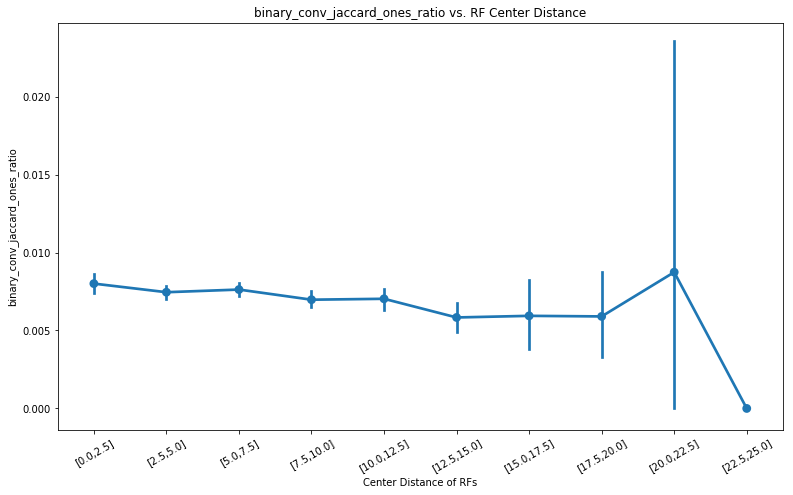

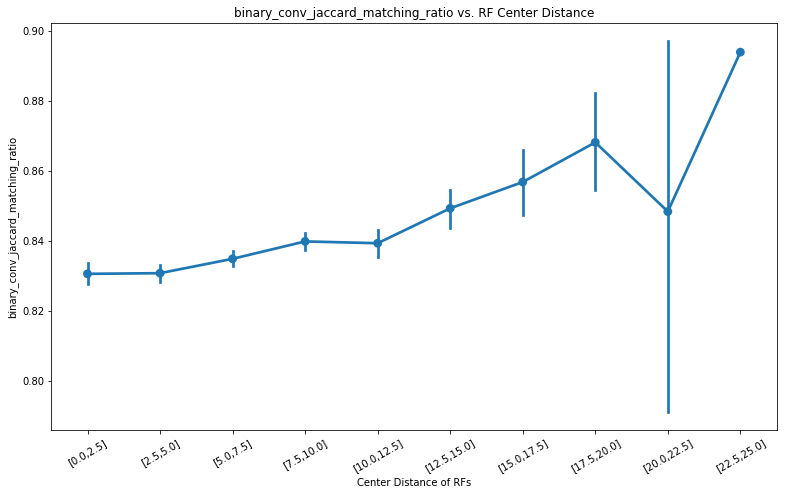

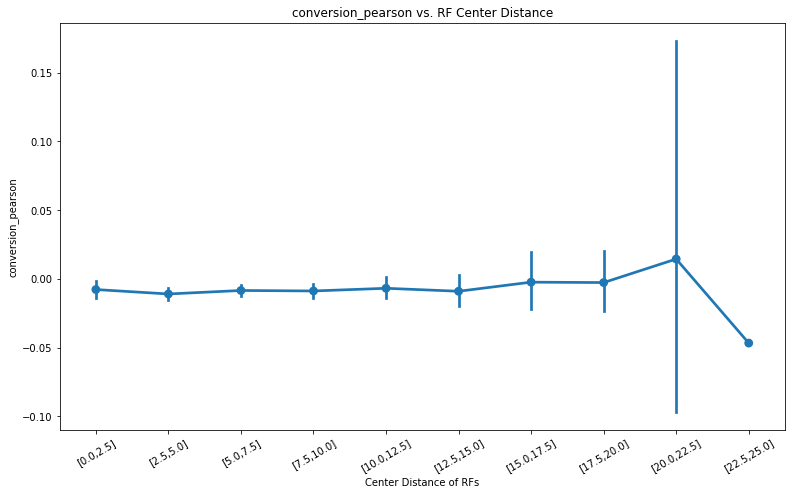

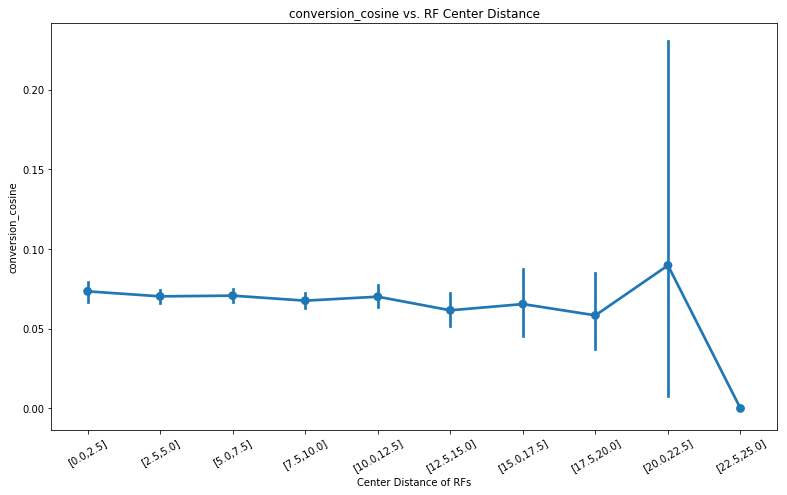

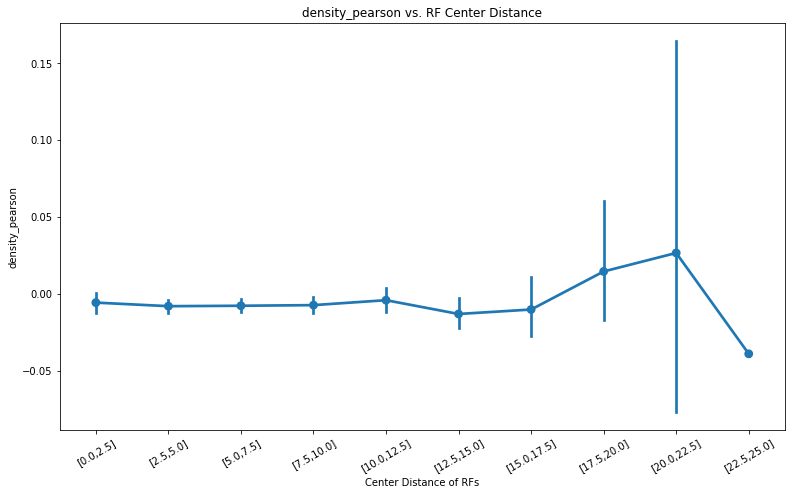

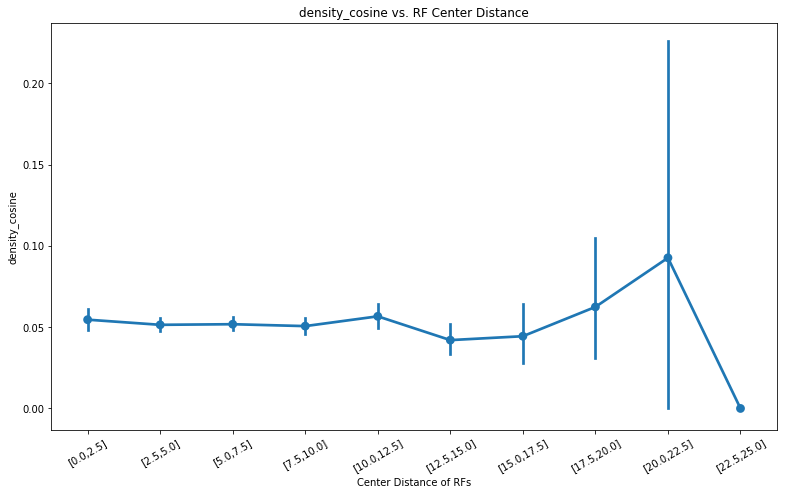

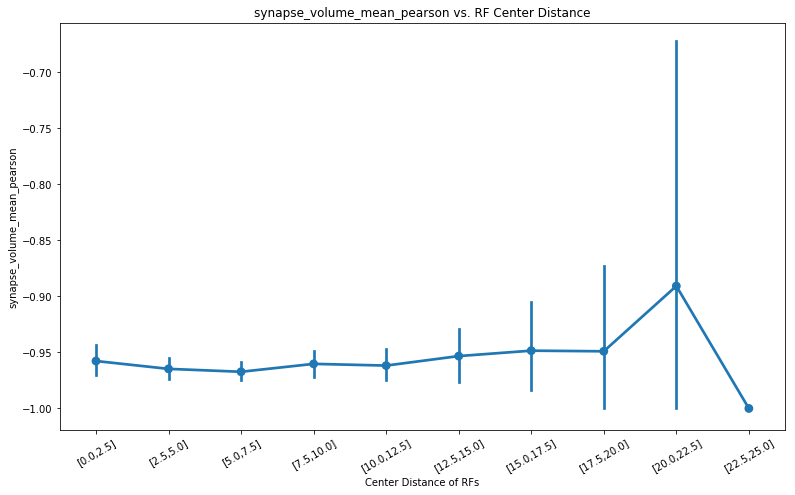

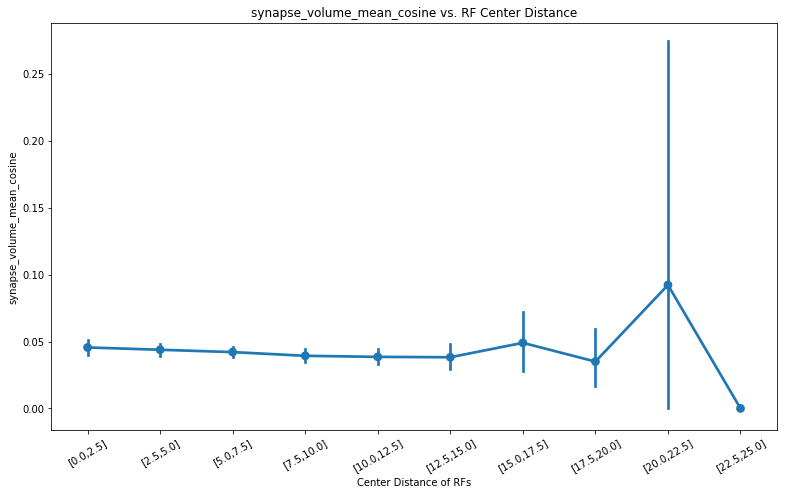

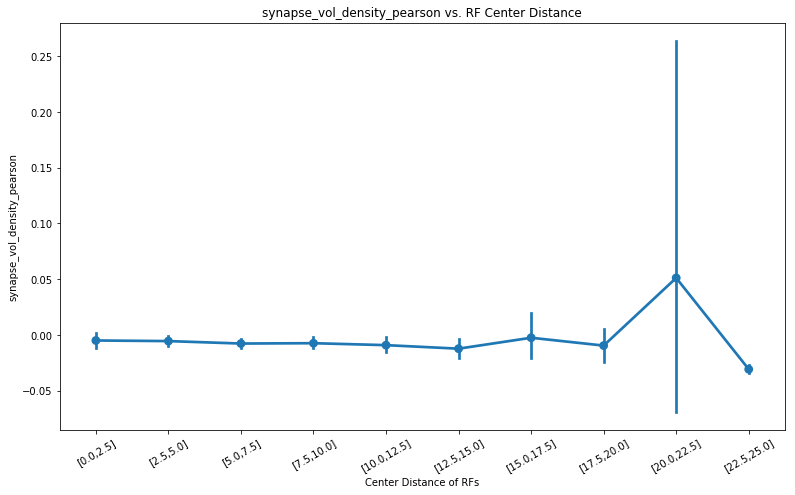

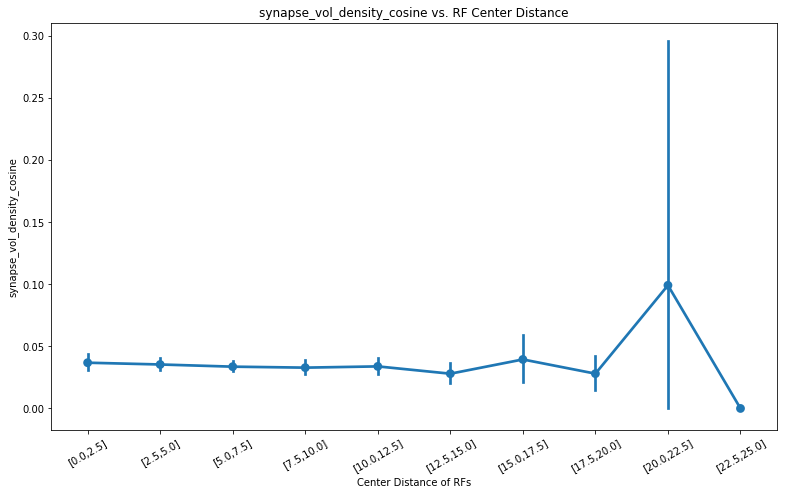

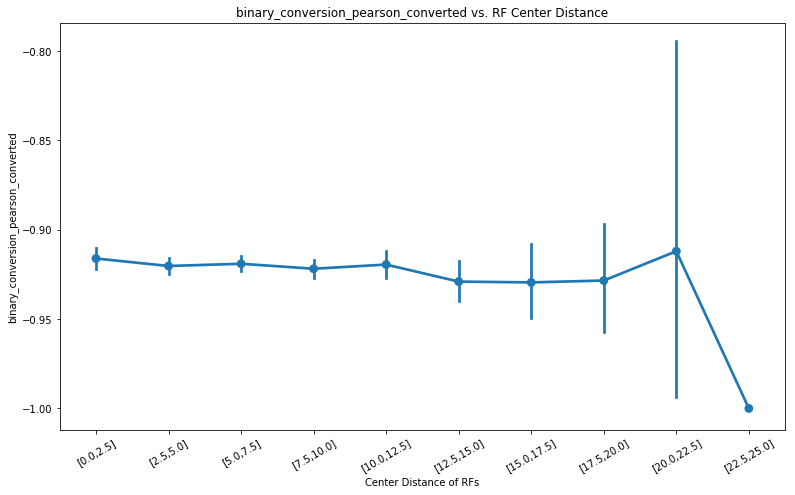

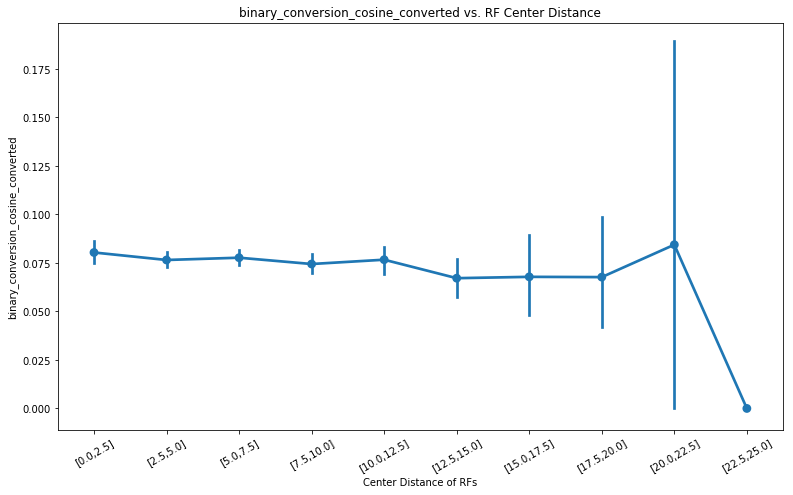

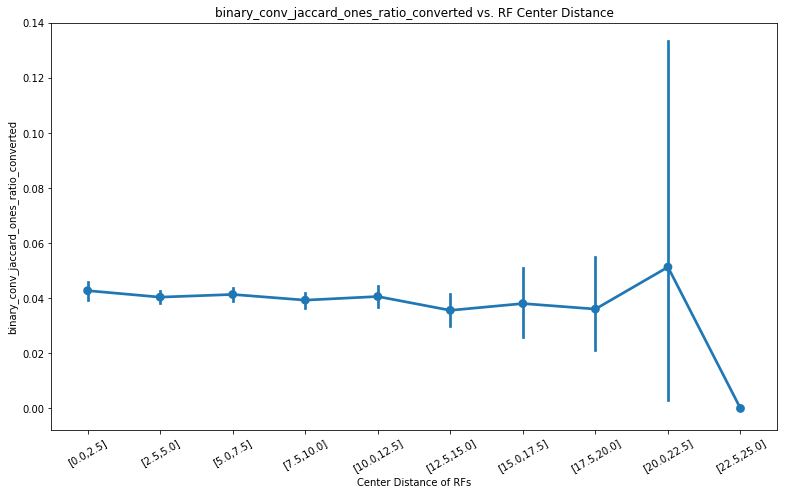

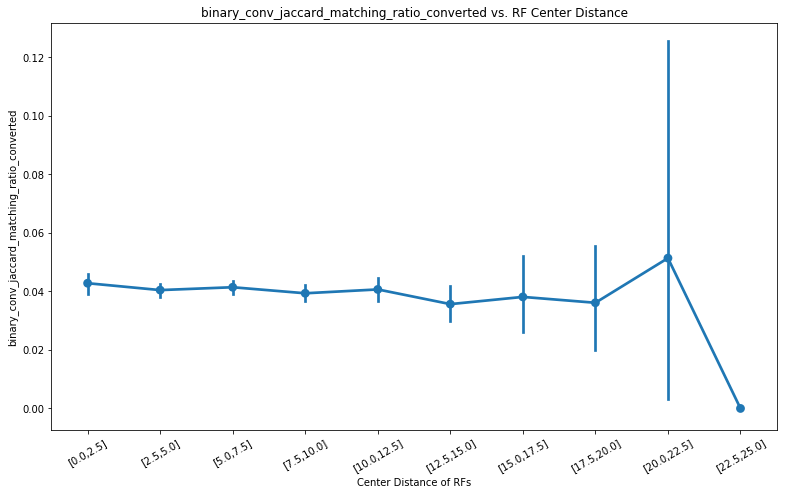

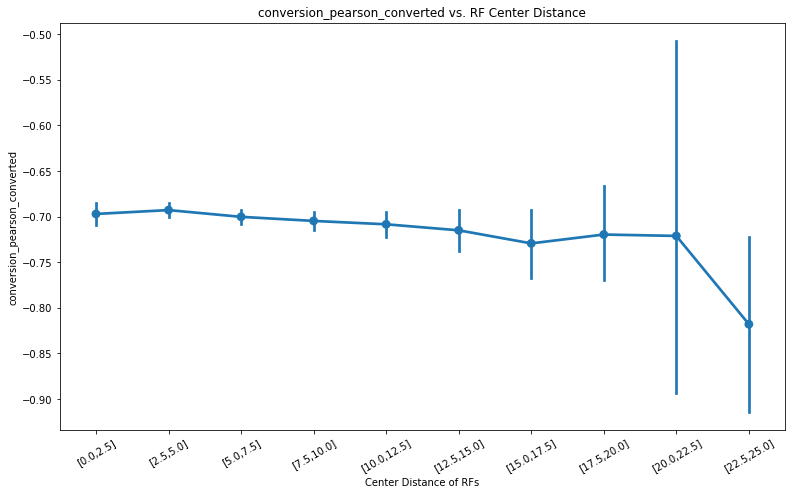

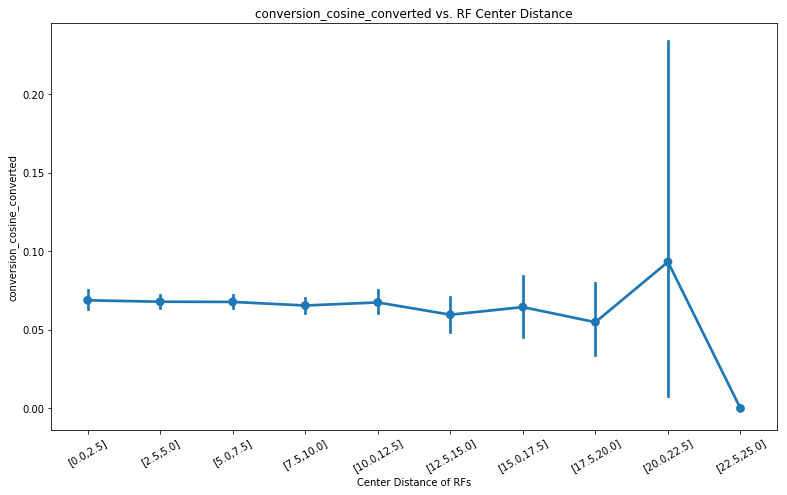

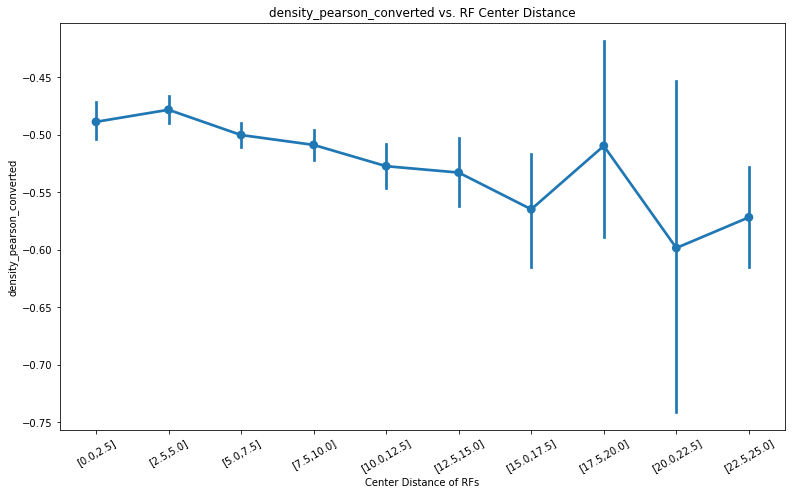

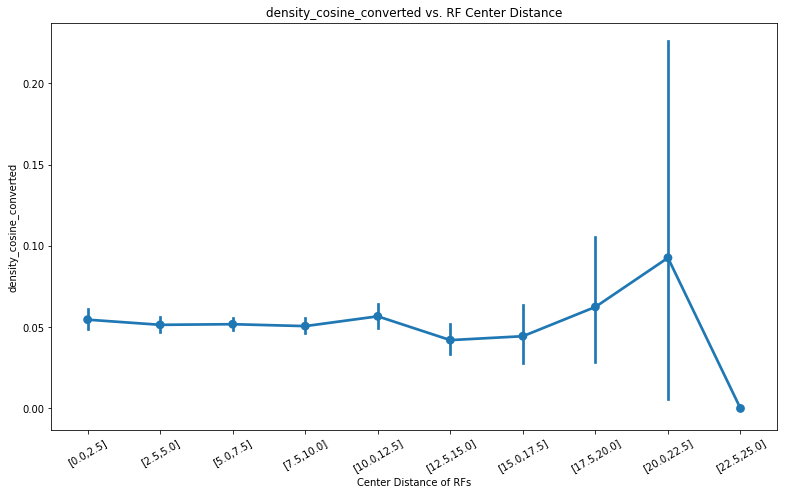

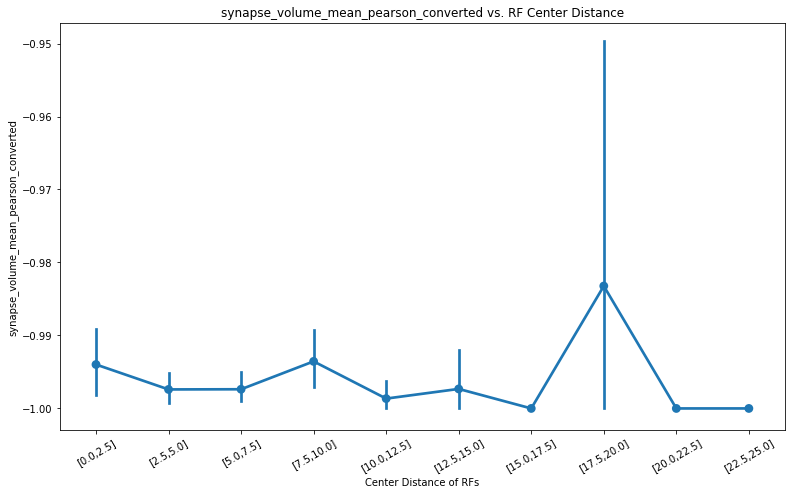

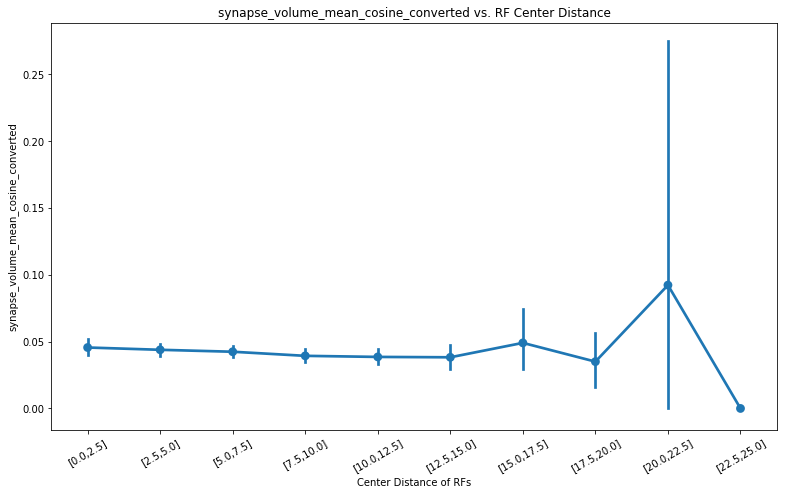

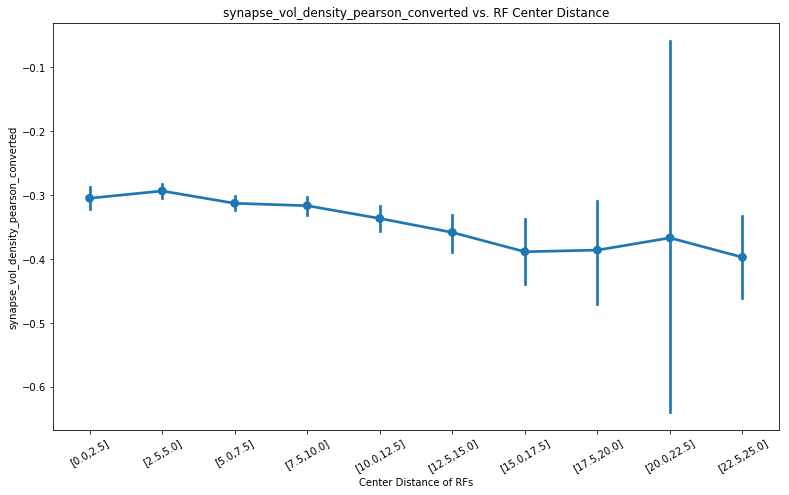

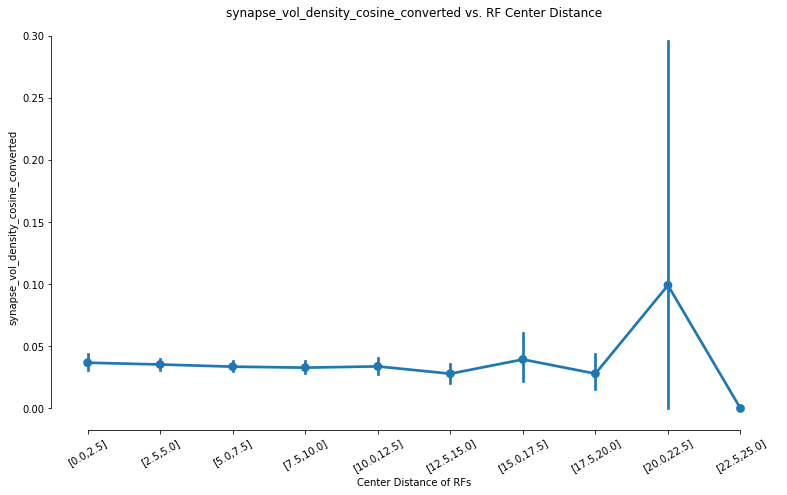

In [17]:
# Doing without Receptive Field Restriction
# def rf_distance_vs_n_shared_seg(stats_choice,rf_bin_edges,ori_bin_edges,
#                    n_seg_shared_threshold = 10,
#                     n_seg_shared_converted_threshold = 10,
#                    rf_threshold=1.5,
#                    ori_confidence=0.5,
#                    von_p_value=0.05):
    

stats_choice =["binary_conversion_pearson",
"binary_conversion_cosine",
"binary_conv_jaccard_ones_ratio",
"binary_conv_jaccard_matching_ratio",
"conversion_pearson",
"conversion_cosine",
"density_pearson",
"density_cosine",
"synapse_volume_mean_pearson",
"synapse_volume_mean_cosine",
"synapse_vol_density_pearson",
"synapse_vol_density_cosine",
"binary_conversion_pearson_converted",
"binary_conversion_cosine_converted",
"binary_conv_jaccard_ones_ratio_converted",
"binary_conv_jaccard_matching_ratio_converted",
"conversion_pearson_converted",
"conversion_cosine_converted",
"density_pearson_converted",
"density_cosine_converted",
"synapse_volume_mean_pearson_converted",
"synapse_volume_mean_cosine_converted",
"synapse_vol_density_pearson_converted",
"synapse_vol_density_cosine_converted"]


rf_bin_edges=rf_bin_edges
ori_bin_edges = bin_edges
n_seg_shared_threshold = 10
n_seg_shared_converted_threshold = 0
rf_threshold=1.25
ori_confidence=-10000
von_p_value=10000
    
synapse = (pinky.Synapse - pinky.SynapseExclude) & pinky.CurrentSegmentation
segment = (pinky.Segment - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = (pinky.AllenSoma - pinky.SegmentExclude) & pinky.CurrentSegmentation
soma = soma & "cell_class='excitatory'"

"""calculate the specifics for the bins based on the bin edges given
 - Need to change this for the correct 
"""
###Receptive Field
#calculates the centers of the bins used for the receptive field
#     cbin_centers = np.hstack((np.nan, np.round((rf_bin_edges[1:] + rf_bin_edges[:-1])/2, decimals=2), np.nan))
#     #creates labels for the receptive field edges
#     cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(rf_bin_edges[:-1], rf_bin_edges[1:])]
#     cbin_labels

### Need to change for the SFN project
rf_bin_edges = np.linspace(0,25,11)
# cbin_centers = np.hstack([np.nan,np.linspace(2.5,25,10),np.nan])
# cbin_labels = ['{:.1f}'.format(a) for a in cbin_centers]

cbin_centers = np.hstack((np.nan, np.round((rf_bin_edges[1:] + rf_bin_edges[:-1])/2, decimals=2), np.nan))
#creates labels for the receptive field edges
cbin_labels = ['[{:.1f},{:.1f}]'.format(*a) for a in zip(rf_bin_edges[:-1], rf_bin_edges[1:])]






###Orientation
rad2deg = 180/np.pi
# turns all of the bin edges into degrees with no decimal
be = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_bin_edges]])
#creates the bin boundary markings with [low - high]
bin_labels = list(zip(be[:-1], be[1:]))

#calculates the bin centers
bin_centers = np.round((ori_bin_edges[1:] + ori_bin_edges[:-1])/2 * rad2deg, decimals=2)


"""
Gets the segments with the acceptable rf thresholds
"""

# functional metrics for each functional soma pair (restricting by spattune fitting significance)

sig_units_rf = spattune.BestSTA.Loc & 'sta_snr > ' + str(rf_threshold) & segment
sig_unit_pairs_rf = (sig_units_rf.proj(segment_id1 = 'segment_id') * 
                  sig_units_rf.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

print("Number of significant receptive field neurons = " + str(len(sig_units_rf)))

rf_table = (spattune.BestSTACorr.proj("center_dist",rf_corr_coef="union_corr_r2",
                          segment_a="segment_id1",segment_b="segment_id2")
                          & sig_units_rf.proj(segment_a="segment_id") &
                          sig_units_rf.proj(segment_b="segment_id")) & "center_dist < 27"
print("Length of rf correlation = " + str(len(rf_table)))

"""
build the pref_rel table to use for the orinetation data

This table just needs the 
1) segment_id
2) von_r2 (orientation preference)
--> for all of the tuned segments
"""
tuned = 'confidence > ' + str(ori_confidence)
#get the significantly tuned segments
# sig_units_op = radtune.BestVonFit.Unit & 'von_p_value <= ' + str(von_p_value) & tuned & segment
sig_units_op = radtune.BestVonFit.Unit & segment
print("Number of significanlty orientationally tuned neurons = " + str(len(sig_units_op)))


#gets the significantly tuned neurons and their differences in combinational pairs 
sig_unit_pairs_op = (radtune.BestVonCorr() & sig_units_op.proj(segment_id1="segment_id") 
                 & sig_units_op.proj(segment_id2="segment_id")).proj("diff_pref_ori")

sig_unit_pairs_op = sig_unit_pairs_op.proj(segment_a="segment_id1",
                                           segment_b="segment_id2",
                                           dori="diff_pref_ori")

print("Length of pairwise orientation difference table = " + str(len(sig_unit_pairs_op)))


"""
goes and applies the restrictions and then gets the desired stat
binary_conv_jaccard_ones_ratio=null : float                        # a / (a + b + c  + d) for jaccard similarity of binary conversion rate
binary_conv_jaccard_matching_ratio=null : float                        # ( a + d )/ (a + b + c  + d) for jaccard similarity of binary conversion rate


Examples of Possible stats: 
"n_seg_shared_converted",
"binary_conversion_pearson",
"binary_conv_jaccard_ones_ratio",
"conversion_pearson",
"density_pearson",
"synapse_vol_density_pearson",
"synapse_vol_density_cosine",
"binary_conversion_pearson_converted",
"binary_conv_jaccard_ones_ratio_converted",
"conversion_pearson_converted",
"density_pearson_converted",
"synapse_vol_density_pearson_converted",
"synapse_vol_density_cosine_converted",

"""

stats_choice_original = stats_choice.copy()

#remove number of segments shared if already there
if "n_seg_shared" in stats_choice:
    stats_choice.remove("n_seg_shared")



sign_contact_correlations_only_shared_threshold = fc.ContactCorrelation() & "n_seg_shared>" + str(n_seg_shared_threshold)
print("sign_contact_correlations_only_shared_threshold = " + str(len(sign_contact_correlations_only_shared_threshold)))
sign_contact_correlations = sign_contact_correlations_only_shared_threshold & "n_seg_shared_converted>" + str(n_seg_shared_converted_threshold)
print("sign_contact_correlations with both shared number threshold and shared number converted threshold = " + str(len(sign_contact_correlations)))
sign_contact_correlations = sign_contact_correlations.proj(*stats_choice,
                                                           segment_a="segment_id",
                                                           n_seg_shared_contacts="n_seg_shared",

                                                          )

"""gets table where have every connection from segment_a to segment b anf the number of n_seg_shared stacked on a 
repeat but the ids for a and b are switched  """
shi = fc.SharedInput.proj("n_seg_shared",segment_a="segment_id")

print("len(shi) = " + str(len(shi)))
print("len(shi restricted by the contact correlations with n_seg_shared threshold) = " + str(len(shi & sign_contact_correlations_only_shared_threshold.proj(segment_a="segment_id"))))
print("len(shi restricted by the contact correlations with n_seg_shared threshold AND converted threshold) = " + str(len(shi & sign_contact_correlations)))

new_shi = shi * sign_contact_correlations

""" takes all of the possible shared input combinations:
1) gets this correlation table and renames seg a and b and uses that to restrict the shared input combinations and attach the rf correlation
2) Further restricts to only those TUNED with prefered orientation (and adds on the orientation for a and b)
3) Restrict to only significant rective fields for both segment A and B by DOES NOT ATTACH THE RF score

"""
crel = shi * rf_table * sig_unit_pairs_op
new_crel =  new_shi * rf_table * sig_unit_pairs_op
print((len(crel),len(new_crel)))
crel = new_crel

"""Pulls down the data and starts doing pandas altering"""
cdf = pd.DataFrame(crel.fetch())
#drop any rows with nans
cdf = cdf.dropna()

#gets the bins of the correlations of the receptive fields
#     cdf['bcorr'] = cbin_centers[(np.digitize(cdf['rf_corr_coef'], rf_bin_edges))]
cdf['bcorr'] = cbin_centers[(np.digitize(cdf['center_dist'], rf_bin_edges))]
#makes the bins of the corelation of the receptive fields as floats
cdf['bcorr'] = np.array(cdf['bcorr']).astype(float)
#bins the difference in orientation
cdf['bdori'] = bin_centers[(np.digitize(np.abs(cdf["dori"]), ori_bin_edges))-1]


#makes the stats all floats
for s in stats_choice_original:
    cdf[s] = np.array(cdf[s]).astype(float)


#Will graph the marginal of the center dist vs number of shared segments
for s in stats_choice_original:
    #calculates the actual histograms
    gs = plt.GridSpec(1,1)
    fig = plt.figure(figsize=(13,7.5))
    ax_heat_shared = fig.add_subplot(gs[0,0])

    ax = sns.pointplot("bcorr", s,data = cdf) 
    ax.set_title(s + " vs. RF Center Distance")
    #ax.set_xticklabels(['{}'.format(a) for a in cbin_labels])
    ax.set_xticklabels(cbin_labels,rotation=30)
    ax.set_xlabel('Center Distance of RFs')
    ax.set_ylabel(s)

sns.despine(trim=True)
# from matplotlib import rcParams

# # figure size in inches
# rcParams['figure.figsize'] = 11.7,8.27
        
    
    
    
    
#     #now iterate through and do allof the graphs for every stat requested and display bin values
#     for s in stats_choice_original:

#         #calculates the actual histograms
#         gs = plt.GridSpec(1,2)
#         fig = plt.figure(figsize=(13,7.5))
#         ax_heat_shared = fig.add_subplot(gs[0,0])

#         #groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
#         df2  = cdf
#         df2 = df2.groupby(['bdori', 'bcorr'])[s].mean().reset_index()
#         #turns the pairs into a pivot table that can be visualized as a heatmap
#         df2 = df2.pivot('bdori', 'bcorr', s)
#         #graphs the heat map
#         g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_shared)
#         #applys the y labels for the shared segments (have to format it so they will show the degrees)
#         g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#         #sets the rf labels and rotates them slightly
#         g.set_xticklabels(cbin_labels, rotation=30)
#         #inverts the y axis so that they are going up in value as graph goes up
#         g.invert_yaxis()
#         #sets no tick marks
#         g.tick_params(length=0)
#         #set labels
#         g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
#         g.set_ylabel(r'$\langle$shared segments$\rangle$')
#         g.set_title('Average ' + str(s) +  "\n shared_threshold = " + str(n_seg_shared_threshold) + ", \n converted shared_threshold = " + str(n_seg_shared_converted_threshold)
#                     + "\n rf threshold=" + str(rf_threshold))
        
#         ax_heat_count = fig.add_subplot(gs[0,1])

#         #groups the pairs by the binned directional orientation and gets the mean of the number of shared segments
#         df2  = cdf
#         df2 = df2.groupby(['bdori', 'bcorr'])[s].count().reset_index()
#         #turns the pairs into a pivot table that can be visualized as a heatmap
#         df2 = df2.pivot('bdori', 'bcorr', s)
#         #graphs the heat map
#         g = sns.heatmap(df2, square=True, cmap='plasma', annot=True, linewidths=2,ax=ax_heat_count,fmt='g')
#         #applys the y labels for the shared segments (have to format it so they will show the degrees)
#         g.set_yticklabels(['{}°-{}°'.format(*a) for a in bin_labels], rotation=0)
#         #sets the rf labels and rotates them slightly
#         g.set_xticklabels(cbin_labels, rotation=30)
#         #inverts the y axis so that they are going up in value as graph goes up
#         g.invert_yaxis()
#         #sets no tick marks
#         g.tick_params(length=0)
#         #set labels
#         g.set_xlabel(r'$\rho$(RF$_1$, RF$_2$)')
#         g.set_ylabel(r'$\langle$Number of pairs in bin$\rangle$')
        
#         #Add title based on all the parameters
        
#         # g.set_title('add title here')
#         g.set_title('Number of pairs in bins')
#         plt.show()



    
    
    



1      -0.065376
3      -0.068046
4      -0.025814
6       0.232516
7      -0.012457
          ...   
7254    0.004319
7255   -0.007846
7256   -0.015260
7257   -0.013974
7258   -0.001528
Name: synapse_vol_density_pearson, Length: 6568, dtype: float64